# Brief introduction to Fourier ptychograhy

In optical system design numerical aperture (NA) defines the acceptance angle of a lens e.g. the larger the lens, the more light is captured. However, manufacturing large lenses is costly and difficult because paraxial approximation gets broken leading to more optical aberrations. Hence, most high-resolution (i.e. high-NA) lenses are actually composed of multiple lenses forming an objective. The design of high-NA objectives is complicated and requires multiple carefully aranged lenses to remove the aberrations. Apart from price and complexity, the high-NA objectives used for imaging have a small depth-of-field and a narrow field-of-view (FOV). Hence, while images with high-resolution can be captured, the visible sample area will be small. 

To overcome all of the complications inherent to high-NA objectives, a computational imaging technique called Fourier ptychography (FPM) was developed. To understand FPM principle one has to understand the simple relationship between NA and image resolution. When the sample is illuminated it will diffract light in all directions, but only a small fraction of the diffracted light will be captured by the imaging sytem. The larger the lens (the larger the NA), the more diffracted light is captured and the higher the resolution of the images. In FPM, low-NA (low-resolution) lenses are used to capture wide-FOV images. The resolution can then be enhanced computationally, by capturing multiple images illuminated from various angles (simply by lighting up different LEDs on the LED array). Changing the illumination angle results in the diffracted specturm being "shifted". Hence, each captured image represents different diffracted specturm components and if all the fields can be stitched together, then the resolution of our wide-FOV image can be enhanced transforming our images from several-megapixels up to a gigapixel.

The geometrical relationship between angular illumination and the resultant diffracted fields is fairly simple. In the image below, basic FPM geometry is shown, where illumination angles $\theta$ are used to compute the diffracted k-space vectors $k$. Vector components of the diffracted fields being sampled by the optical system are computed from basic geometry

\begin{equation}
\sin \theta = (k_x/k_0, k_y/k_0)  = (x/D,y/D).
\end{equation}

In this equation $k_x,k_y$ are the diffracted field components in the Fourier plane (also referred to as k-space), produced by LEDs at positions defined by $(x,y)$ in the LED plane. These vector components are scaled by the hypothenuse values, where in k-space it is given by the wave-vector $k_0 = 1/ \lambda$ and in real space it is given by $D = \sqrt{x^2 + y^2 + z^2}$, where $z$ is the distance from the LED array to the sample. Hence, by illuminating the sample via LEDs at $(x,y)$ the diffracted wave-vectors being sampled by the imaging system will be given by

\begin{equation}
k = (k_x,k_y) = k_0 (\frac{x}{\sqrt{x^2 + y^2 + z^2}}, \frac{y}{\sqrt{x^2 + y^2 + z^2}}).
\end{equation}

These vectors define where each image captured by angular illumination must be placed in the Fourier domain. However, the images cannot be simply added together. For this to happen we need to know the amplitude and phase of each diffracted field, but imaging sensors are only capable of capturing intensity information. For this reason we must recover the phase of each measurement during image synthesis. This is where ptychoLab comes in.

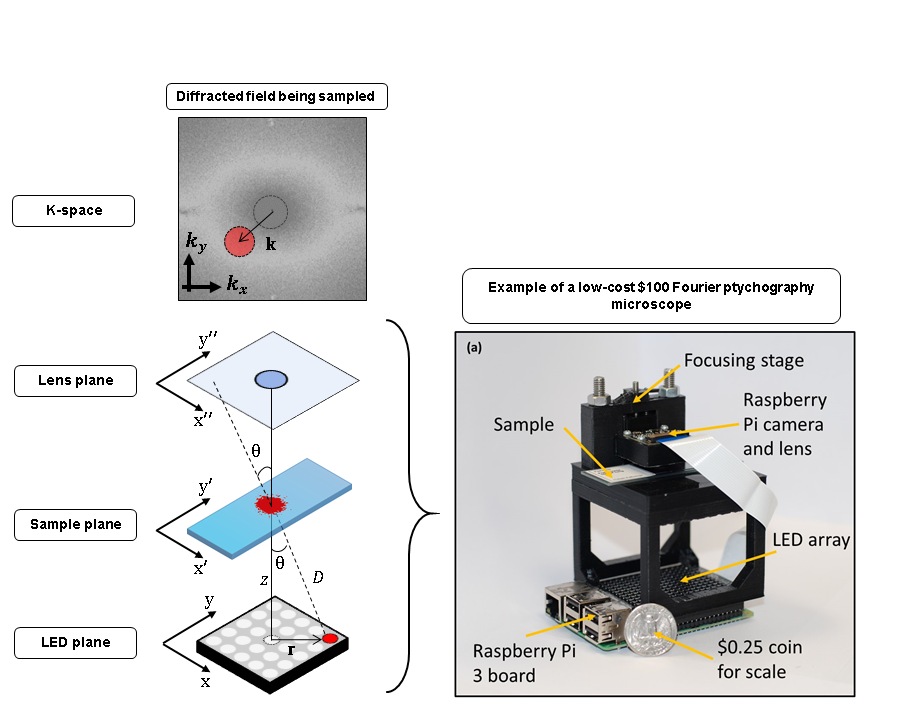

In the above image a low-cost FPM microscope is shown from https://doi.org/10.1038/s41598-019-43845-9. A small data segment is also included in this tutorial (see below) together with data from a microscope under-development https://www.osapublishing.org/abstract.cfm?uri=COSI-2019-CW3A.4 .

# ptychoLab introduction

ptychoLab is a highly modular coding package which can be used for both conventional and Fourier ptychography reconstruction. Due to the modular nature it is easy to modify the code for various tasks and add your own functions, such as a new reconstruction engine or a calibration routine. To understand ptychoLab we need to understand the basic classes contained within, which are briefly outlined below:


 -  ExperimentalData - this class is used to import the experimental data from an .hdf5 file. If file contains the experimental images stored as an image stack (called ptychogram), probe/LED positions and several experimental parameters then the data can be successfully imported and reconstructed.
 -  Optimizer - this class creates various objects from the immutable experimentalData class which will be optimized i.e. are mutable. 
 -  Engines - all the engines used for the reconstruction are based on this class, which take the experimentalData and Optimizer objects as parameters and perform object/probe reconstruction.
 -  Monitor - visualization class used to display the reconstruction process
 -  CalibrationFPM - this package contains k-space position calibration routines caused by misaligned LED positions.


In [9]:
import matplotlib
%gui qt
%matplotlib inline
from fracPy.io import getExampleDataFolder
from fracPy.ExperimentalData.ExperimentalData import ExperimentalData
from fracPy.Optimizable.Optimizable import Optimizable
from fracPy.Optimizable.CalibrationFPM import IlluminationCalibration
from fracPy.engines import ePIE, mPIE, qNewton, mqNewton, zPIE, e3PIE, pcPIE
from fracPy.utils.gpuUtils import getArrayModule, asNumpyArray
from fracPy.Params.Params import Params
from fracPy.monitors.Monitor import Monitor as Monitor
import logging
logging.basicConfig(level=logging.INFO)
from fracPy.utils.utils import ifft2c, fft2c
from fracPy.utils.visualisation import hsvplot
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
import time
import pylab as pl
from IPython import display

from mpl_toolkits import mplot3d

## ExperimentalData class: Loading data in ptychoLab
The data must be stored as a ".hdf5" file, which convieniently enables structured file storage. For ptychographic data, experimental parameters such as wavelenght or pixel size can be convieniently stored together with illumination positions and the actual raw images in a single file.

We start off our demonstration by creating the ExperimentalData() class which is used to load the .hdf5 file. In this example the varible "exampleData" will contain our class.

In [10]:
#%% Create the experimental data class and use it to import the data
exampleData = ExperimentalData()
# define whether processing FPM or conventional Ptychography data
exampleData.operationMode = 'FPM'

# experimental data from the £100 FPM microscope
# full field color data can be found at
# https://doi.org/10.5525/gla.researchdata.687
# fileName = 'raspi_fpm_lung.hdf5'  

# high-quality experimental data from
# https://www.osapublishing.org/abstract.cfm?uri=COSI-2019-CW3A.4
fileName = 'lung_fpm.hdf5'  

filePath = getExampleDataFolder() / fileName
exampleData.loadData(filePath)

## ExperimentalData class: Positions and encoder
The ".hdf5" file must have a field called "encoder" containing the positions of the illumination in SI units (um) and has a 2D shape [N,2], where N is the number of illumination positions used on a X-Y grid.

To use the illumination locations for data reconstruction they must be converted from SI units into pixels in the Fourier domain. The converted physical probe/LED positions can be accessed from our "exampleData" class via the field "positions" which in our example is invoked via "exampleData.positions". Each time the command "exampleData.positions" is used called "positions" are computed on the fly rather than being pre-computed during data import. The reason for this is that ptychoLab contains several routines such as "zPIE" or "LED calibration" where the actual physical experimental positions inside the "encoder" field can be corrected in the presence of experimental errors. Hence, "exampleData.positions" will immediately return Fourier space positions in pixels with the corrections applied, which enables, for example, iterative position updating during the image reconstruction. This is useful for the "zPIE" method used in ptychography where the sample-to-detector distance is adjusted iteratively.

### Advanced
In FPM, most calibration algorithms perform corrections in the Fourier domain rather than real-space. Since we will be modifying Fourier domain positions rathert than the "encoder" values, the switch "exampleData.fixedPositions = True" makes the positions fixed rather than computing them on the fly from "encoder" values.   

In [11]:
exampleData.fixedPositions = True 

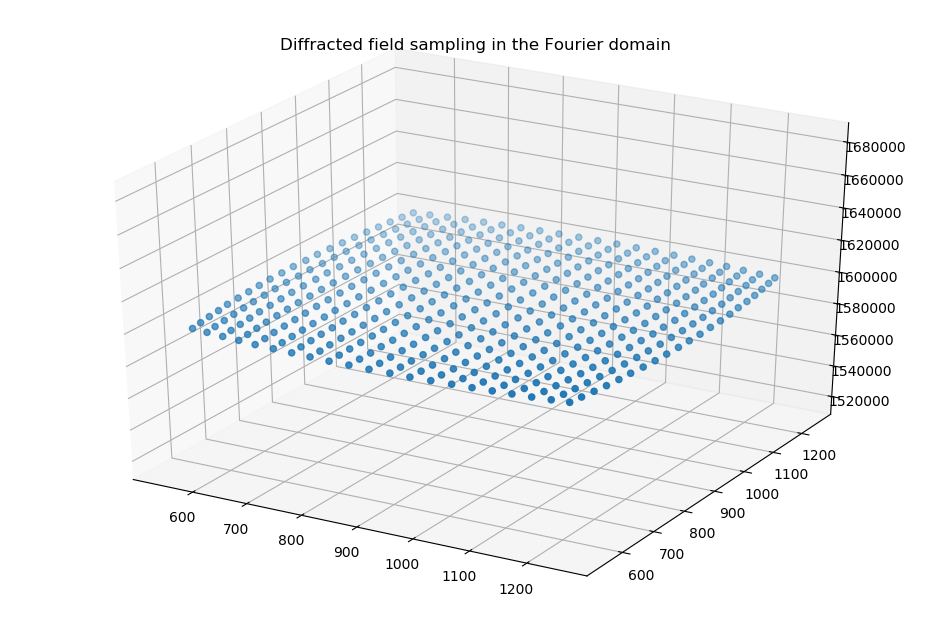

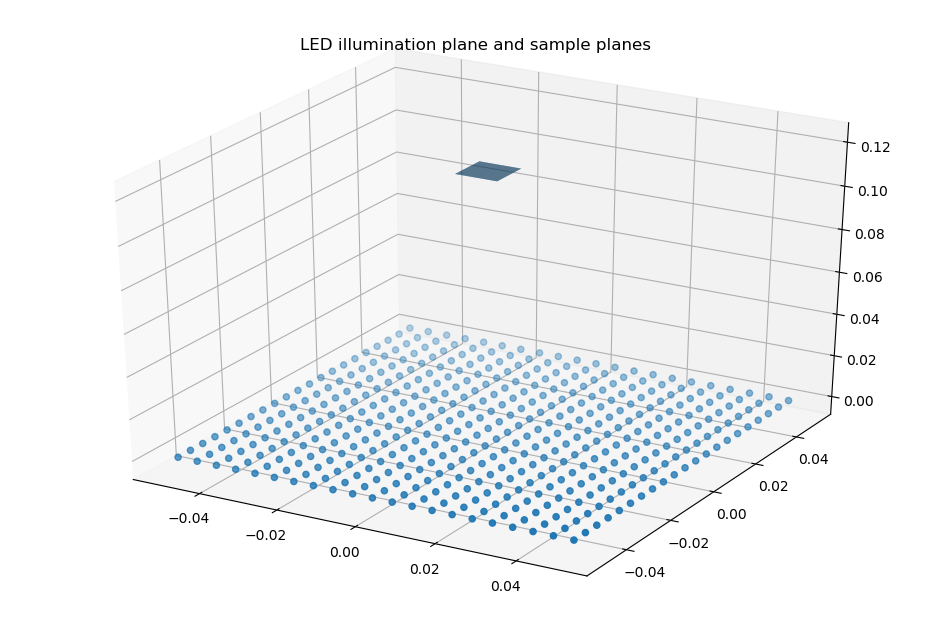

In [12]:
# LED grid coordinates
x=exampleData.encoder[:,0]
y=exampleData.encoder[:,1]
z=exampleData.zo

# Sample grid coordinates
sx,sy=np.mgrid[-1500:1500,-1500:1500]*exampleData.dxd

# Fourier space positions in pixel units computed from the the LED grid coorrdinates
kx=exampleData.positions[:,0]
ky=exampleData.positions[:,1]
k0=1/exampleData.wavelength

# sample plane grid coordinates (for vizualization purposes)
ax = plt.axes(projection='3d')
plt.title('Diffracted field sampling in the Fourier domain')
ax.scatter(kx, ky, k0);
plt.show()


ax = plt.axes(projection='3d')
plt.title('LED illumination plane and sample planes')
ax.scatter(x, y, 0,label='LED plane');
ax.plot_surface(sx, sy, z*np.ones_like(sx),label='sample plane');
plt.show()



## ExperimentalData class: ptychogram
The ".hdf5" file must have a field called "ptychogram" containing the experimental raw images as a 3D array of shape [N,X,Y], where N is the number of images corresponding to each illumination vector in the "encoder" and X-Y are the 2D image dimensions.

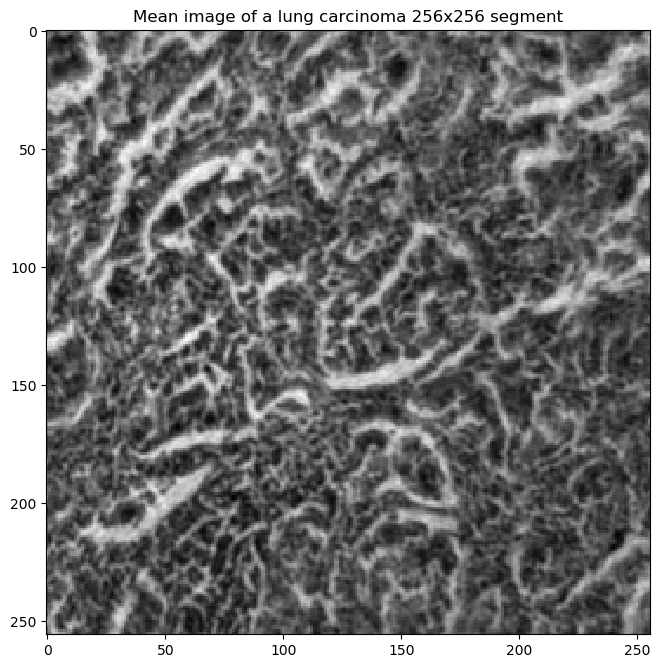

In [13]:
mean_img = np.mean(exampleData.ptychogram,0)
N = exampleData.ptychogram.shape[0]

plt.title('Mean image of a lung carcinoma 256x256 segment')
plt.imshow(mean_img, cmap='gray')
plt.show()

In [14]:
# for i in range(N):
#     plt.clf()
#     plt.subplot(121)
#     plt.title('Image #{}'.format(i))
#     plt.imshow(exampleData.ptychogram[i], cmap='gray')
#     plt.subplot(122)
#     plt.title('LED being used')
#     plt.scatter(x,y,alpha=0.1)
#     plt.scatter(x[i],y[i])
#     plt.gca().set_aspect('equal')
    
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     time.sleep(.01)


## Optimizable class
The ExperimentalData class contains immutable values. The Optimizable class creates object which will be mutable during the reconstruction or calibration procedure. These objects will be the reconstructed object and the probe/pupil. We can use switches to determine how the data should be prepared for the reconstruction. Once everything is set use "prepare_reconstruction()" method.

In FPM the intial object estimate can be computed from the raw data. "Optimizable.initialObject = 'upsampled'" will take the low-resolution raw data and create an upsampled object estimate via interpolation. The probe/pupil is set to be a clear circle representing a fully transparent aperture without any aberration.


In [15]:
#%% Prepare everything for the reconstruction
# now, all our experimental data is loaded into experimental_data and we don't have to worry about it anymore.
# now create an object to hold everything we're eventually interested in
optimizable = Optimizable(exampleData)
optimizable.initialProbe = 'circ'
optimizable.initialObject = 'upsampled'
optimizable.prepare_reconstruction()

INFO:Optimizable:Initial object set to upsampled
INFO:Optimizable:Initial probe set to circ


## Param class
This class holds the parameters to be used on the optimizable objects.

In [16]:
params = Params()
params.gpuSwitch = True
params.positionOrder = 'NA'
params.probePowerCorrectionSwitch = False
params.comStabilizationSwitch = False
params.probeBoundary = True
# params.absorbingProbeBoundary = True
params.adaptiveDenoisingSwitch = True

## Monitor class
This class will create a monitor to visualize the reconstruction. 

In [17]:
# Set monitor properties
monitor = Monitor()
monitor.figureUpdateFrequency = 10
monitor.objectPlot = 'abs'  # complex abs angle
monitor.verboseLevel = 'high'  # high: plot two figures, low: plot only one figure
monitor.objectPlotZoom = .01   # control object plot FoV
monitor.probePlotZoom = .01   # control probe plot FoV

## Engine class
A specific engine can be imported (e.g. ePIE, mPIE etc.) and used on the optimizable class to "optimize" our initial estimates for the object/probe. In this example we use the quasi-Newton method to reconstruct the data, by passing the optimizable, exampleData and monitor objects to be used during the reconstruction


INFO:qNewton:Sucesfully created qNewton qNewton_engine
INFO:qNewton:Wavelength attribute: 6.24999984211172e-07
d:\du\workshop\fracpy\fracPy\engines\BaseReconstructor.py:268: UserWarning: fftshiftSwitch set to false, this may lead to reduced performance
  warnings.warn('fftshiftSwitch set to false, this may lead to reduced performance')


<IPython.core.display.Javascript object>


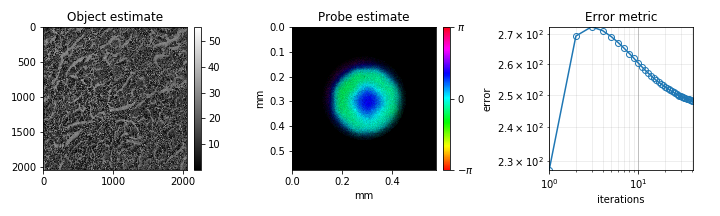

<IPython.core.display.Javascript object>


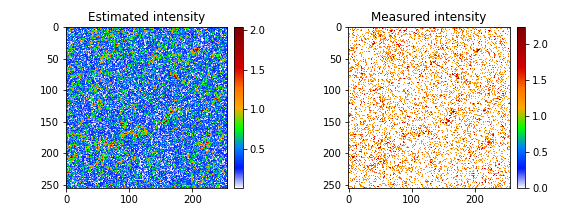

INFO:qNewton:switch to gpu


                                                                                                                       
iteration: 0                                                                                                           
error: 227.3                                                                                                           
estimated linear overlap: 47.7 %                                                                                       
estimated area overlap: 61.8 %                                                                                         
                                                                                                                       
iteration: 10                                                                                                          
error: 259.0                                                                                                           
estimated linear overlap: 44.6 %        

INFO:qNewton:switch to cpu


In [18]:
# Run the reconstructor
engine = qNewton.qNewton(optimizable, exampleData, params, monitor)
engine.numIterations = 50
engine.betaProbe = 1
engine.betaObject = 1

%matplotlib notebook
engine.doReconstruction()
%matplotlib inline

## Calibrator class
The reconstruction above shows a displaced probe/pupil which tries to account for lateral LED array shift. If the reconstructor shifts the probe, then it is an indicator that there are some model mismatch errors. Fortunately, translational errors can be corrected by shifting the pupil, which fortunately happens in this case due to the self-healing nature of the algorithm (in some cases you can see the reconstructed pupil being off-center). 

If the errors are large there will be visible artefacts affecting the results. The misplaced LED array errors cause  "exampleData.positions" to not represent the actual data. Fortunately, the calibrator class can be used to do the corrections. In this case we will assume translational errors i.e. the LED array was displaced laterally with respect to the sample defined by "calib.fitMode = 'Translation'" switch. Simply create the IlluminationCalibration() class with the exampleData object and use the runCalibration() method. This will do all of the position calibrations.

translation [16.39081966  7.70040089]


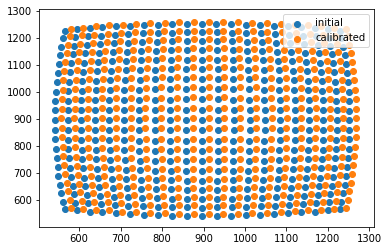

INFO:Optimizable:Initial object set to upsampled
INFO:Optimizable:Initial probe set to circ


In [19]:
# NOTE: exampleData.fixedPositions = True must be used!
# decide whether the positions will be recomputed each time they are called or whether they will be fixed
# without the switch, positions are computed from the encoder values
# with the switch calling exampleData.positions will return positions0
exampleData.fixedPositions = True
calib = IlluminationCalibration(exampleData)
# calib.plot=True
# calib.fit_mode = 'SimilarityTransform'
calib.fit_mode = 'Translation'
calibrated_positions, _, calib_matrix = calib.runCalibration()


print("translation", calib_matrix.translation)
# print("rotation", calib_matrix.rotation/np.pi*180)
# print("scale", calib_matrix.scale)
plt.scatter(exampleData.positions0[:,0], exampleData.positions0[:,1],label='initial')
plt.scatter(calibrated_positions[:,0],calibrated_positions[:,1],label='calibrated')
plt.legend()
plt.show()


# update the fixed non-dynamically computed positions with the new ones
exampleData.positions0 = calibrated_positions
optimizable.prepare_reconstruction()

INFO:Optimizable:Initial object set to upsampled
INFO:Optimizable:Initial probe set to circ
INFO:qNewton:Sucesfully created qNewton qNewton_engine
INFO:qNewton:Wavelength attribute: 6.24999984211172e-07
d:\du\workshop\fracpy\fracPy\engines\BaseReconstructor.py:268: UserWarning: fftshiftSwitch set to false, this may lead to reduced performance
  warnings.warn('fftshiftSwitch set to false, this may lead to reduced performance')


<IPython.core.display.Javascript object>


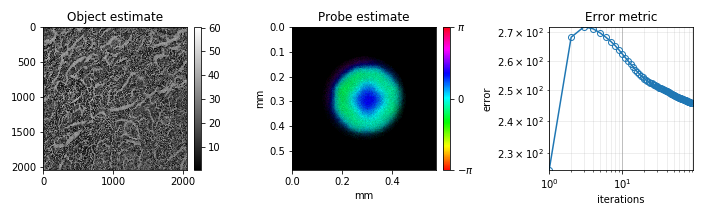

<IPython.core.display.Javascript object>


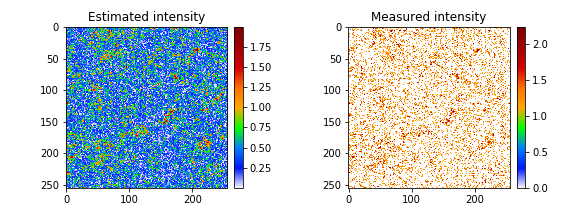

INFO:qNewton:switch to gpu


                                                                                                                       
iteration: 0                                                                                                           
error: 224.6                                                                                                           
estimated linear overlap: 47.7 %                                                                                       
estimated area overlap: 61.7 %                                                                                         
                                                                                                                       
iteration: 10                                                                                                          
error: 261.0                                                                                                           
estimated linear overlap: 45.5 %        

INFO:qNewton:switch to cpu


In [20]:
#%% Prepare everything for the reconstruction
# now, all our experimental data is loaded into experimental_data and we don't have to worry about it anymore.
# now create an object to hold everything we're eventually interested in
optimizable = Optimizable(exampleData)
optimizable.initialProbe = 'circ'
optimizable.initialObject = 'upsampled'
optimizable.prepare_reconstruction()

# Run the reconstructor
engine = qNewton.qNewton(optimizable, exampleData, params, monitor)
engine.numIterations = 100
engine.betaProbe = 1
engine.betaObject = 1
engine.params.momentumAcceleration = False

%matplotlib notebook
engine.doReconstruction()
try:engine._move_data_to_cpu()
except:pass
%matplotlib inline

# Reconstruction vs raw data

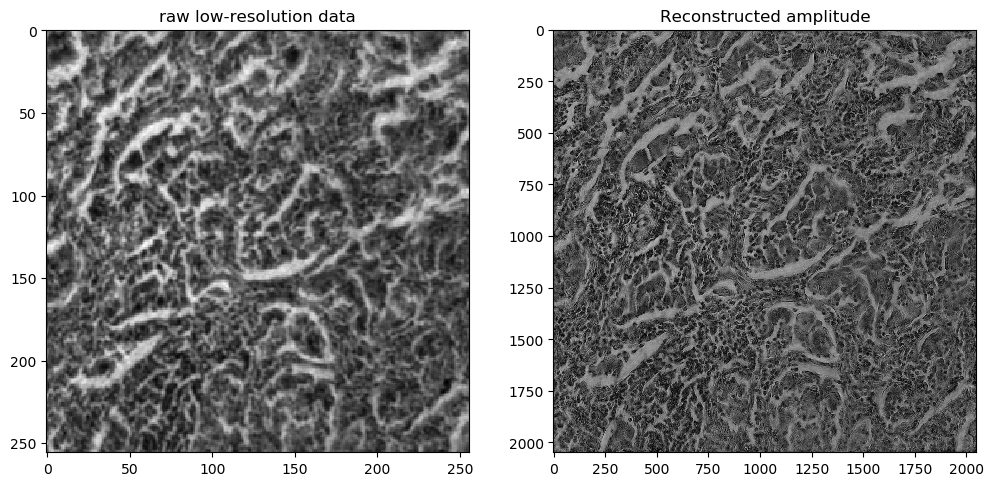

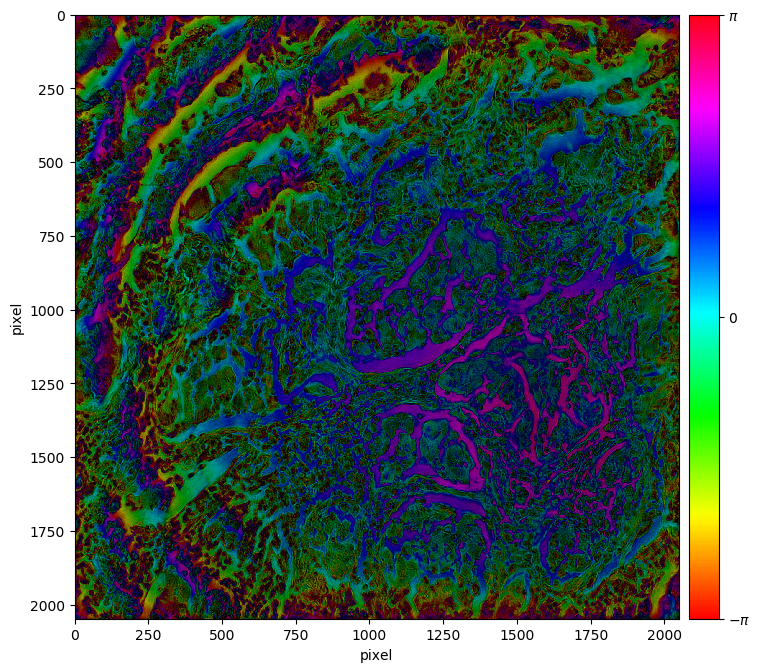

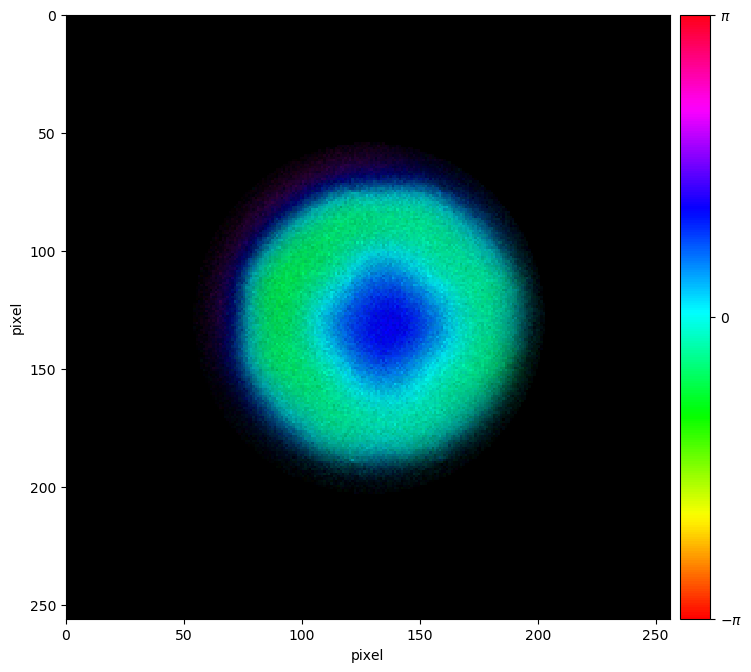

In [21]:
from fracPy.utils.visualisation import modeTile, complex_plot, complex_to_rgb
import tifffile
try:engine._move_data_to_cpu()
except:pass
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

object_estimate = np.squeeze(fft2c(optimizable.object)[..., :,:])
probe_estimate = np.squeeze(optimizable.probe[..., :,:])

plt.figure()
plt.subplot(121)
plt.title('raw low-resolution data')
plt.imshow(mean_img,cmap='gray')
plt.subplot(122)
plt.title('Reconstructed amplitude')
plt.imshow(abs(object_estimate),cmap='gray')
plt.show()

complex_plot(complex_to_rgb(object_estimate))
complex_plot(complex_to_rgb(probe_estimate))


## Improving the optimization via momentum acceleration
We will also demonstrate momentum accelerated quasi-Newton engine. The updated object/probe are further improved via momentum accelerated optimizers. This function supports standard "momentum" acceleration as well as adaptive momentum (ADAM) and adaptive momentum with Nesterov momentum (NADAM). Simply set "engine.momentum_method" to 'ADAM, 'NADAM' or 'momentum'. It is also easy to implement a custom momentum accelerator by adding a single function to the existing qNewton code due to the modular code structure.

INFO:Optimizable:Initial object set to upsampled
INFO:Optimizable:Initial probe set to circ
INFO:mqNewton:Sucesfully created momentum accelerated qNewton engine
INFO:mqNewton:Wavelength attribute: 6.24999984211172e-07
d:\du\workshop\fracpy\fracPy\engines\BaseReconstructor.py:268: UserWarning: fftshiftSwitch set to false, this may lead to reduced performance
  warnings.warn('fftshiftSwitch set to false, this may lead to reduced performance')


<IPython.core.display.Javascript object>


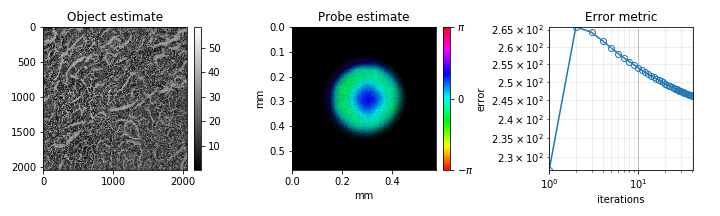

<IPython.core.display.Javascript object>


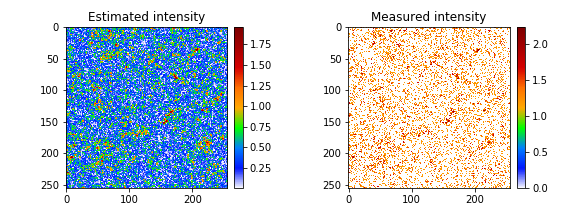

INFO:mqNewton:switch to gpu


Momentum engines implemented: momentum, ADAM, NADAM
Momentum engine used: NADAM
                                                                                                                       
iteration: 0                                                                                                           
error: 226.6                                                                                                           
estimated linear overlap: 46.9 %                                                                                       
estimated area overlap: 63.9 %                                                                                         
                                                                                                                       
iteration: 10                                                                                                          
error: 253.3                                                                    

INFO:mqNewton:switch to cpu


In [22]:
#%% Prepare everything for the reconstruction
# now, all our experimental data is loaded into experimental_data and we don't have to worry about it anymore.
# now create an object to hold everything we're eventually interested in
optimizable = Optimizable(exampleData)
optimizable.initialProbe = 'circ'
optimizable.initialObject = 'upsampled'
optimizable.prepare_reconstruction()

# Run momentum accelerated reconstructor
engine = mqNewton.mqNewton(optimizable, exampleData, params, monitor)
engine.numIterations = 50
engine.betaProbe = 1
engine.betaObject = 1
engine.beta1 = 0.5
engine.beta2 = 0.5
engine.betaProbe_m = 0.25
engine.betaObject_m = 0.25
engine.momentum_method = 'NADAM'

%matplotlib notebook
engine.doReconstruction()
try:engine._move_data_to_cpu()
except:pass
%matplotlib inline


In [ ]:
from fracPy.utils.visualisation import modeTile, complex_plot, complex_to_rgb
import tifffile
try:engine._move_data_to_cpu()
except:pass
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

object_estimate = np.squeeze(fft2c(optimizable.object)[..., :,:])
probe_estimate = np.squeeze(optimizable.probe[..., :,:])

plt.figure()
plt.subplot(121)
plt.title('raw low-resolution data')
plt.imshow(mean_img,cmap='gray')
plt.subplot(122)
plt.title('Reconstructed amplitude')
plt.imshow(abs(object_estimate),cmap='gray')
plt.show()

complex_plot(complex_to_rgb(object_estimate))
complex_plot(complex_to_rgb(probe_estimate))

def norm(im):
    return np.uint8(im / np.max(im) * 255)

# now save the data
tifffile.imsave('./object_amplitude.png',norm(abs(object_estimate)))
tifffile.imsave('./object_phase.png',norm(np.angle(object_estimate)+ np.pi))
tifffile.imsave('./raw.png',norm(mean_img))
tifffile.imsave('./complex_pupil.png',norm(complex_to_rgb(probe_estimate)))
tifffile.imsave('./complex_object.png',norm(complex_to_rgb(object_estimate)))
engine.saveResults('./lung')


